In [18]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from torch import Tensor
import torch
import torch.nn as nn
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from torch import Tensor
import torch
import torch.nn as nn
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Pre-processing Data

In [50]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [51]:
dcs_tree_clf = DecisionTreeClassifier(random_state=0)
dcs_tree_clf.fit(df.drop(columns=['depvar']), df['depvar'])
dcs_tree_clf.score(df.drop(columns=['depvar']), df['depvar'])

feature_imp = dcs_tree_clf.feature_importances_

for_del_idx = [i if (_<0.015) else None for i, _ in enumerate(feature_imp)]

extract_del_idx = list()
for i in for_del_idx:
  if i is not None:
    extract_del_idx.append(i)

col_list = list(df.drop(columns=['depvar']).columns)

extract_del_idx.reverse()

proc_col = list()
for i in extract_del_idx:
  del col_list[i]
  
proc_col = col_list

In [52]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [10]:
# 정규화  오히려 정규화하고 점수 더 안좋아짐
# scaler = StandardScaler()
# X_train = torch.FloatTensor(scaler.fit_transform(X_train.to_numpy()))
# y_train = torch.LongTensor(y_train.to_numpy())

In [25]:
X_train.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high
18458,0.1114,38000.0,14.15,0,0,0,6415,33,0,0,0,17929,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,16500,16425.0,0.0,1,19,541.29,0.142,0.0,0.0,2260.56,710,714
62440,0.1335,34000.0,9.49,0,1,1,9396,41,0,0,3472,156954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,10000,10000.0,0.0,1,15,338.63,0.347,0.0,0.0,927.68,660,664
68916,0.1144,92000.0,33.76,0,1,0,11500,32,0,0,480,211105,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,11000,11000.0,0.0,1,19,362.43,0.302,0.0,0.0,1590.61,715,719
44237,0.1499,58000.0,18.50,1,1,0,9351,30,0,0,0,190110,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,4000,4000.0,0.0,1,7,138.65,0.567,0.0,0.0,943.30,660,664
16707,0.0967,69600.0,4.84,0,0,0,13532,15,0,0,0,204145,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1250,1250.0,0.0,1,6,40.15,0.321,0.0,0.0,195.01,730,734


In [53]:
# Data 증축 전, 결과 값 비율
print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))

Before OverSampling, counts of label '0': 53956
Before OverSampling, counts of label '1': 26044


In [54]:
def summarize_classification_result(model, X, y):
    y_pred = model.predict(X)
    print(accuracy_score(y, y_pred))
    print(f1_score(y, y_pred))
    print(classification_report(y, y_pred))
    print(confusion_matrix(y, y_pred))
    # sns.heatmap(confusion_matrix(y, y_pred), annot=True)

In [23]:
# 랜덤포레스트 방식 f1 = 0.477
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)

summarize_classification_result(randomforest, X_valid, y_valid)

0.7412
0.4772773177135932
              precision    recall  f1-score   support

           0       0.75      0.92      0.83     13533
           1       0.69      0.37      0.48      6467

    accuracy                           0.74     20000
   macro avg       0.72      0.64      0.65     20000
weighted avg       0.73      0.74      0.71     20000

[[12461  1072]
 [ 4104  2363]]


In [26]:
# Hard Voting 방식 f1 = 0.473
clf1 = DecisionTreeClassifier()
clf2 = RandomForestClassifier()
clf3 = XGBClassifier()
clf4 = LGBMClassifier()

hardvoting = VotingClassifier(estimators=[("tree", clf1), ("forest", clf2), ("xgb", clf3), ("lgbm", clf4)], voting='hard')
hardvoting = hardvoting.fit(X_train, y_train)
summarize_classification_result(hardvoting, X_valid, y_valid)

0.7435
0.4735221674876848
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     13533
           1       0.70      0.36      0.47      6467

    accuracy                           0.74     20000
   macro avg       0.73      0.64      0.65     20000
weighted avg       0.74      0.74      0.72     20000

[[12563   970]
 [ 4160  2307]]


In [27]:
# Soft Voting 방식 f1 = 0.52
softvoting = VotingClassifier(estimators=[("tree", clf1), ("forest", clf2), ("xgb", clf3), ("lgbm", clf4)], voting='soft')
softvoting = softvoting.fit(X_train, y_train)
summarize_classification_result(softvoting, X_valid, y_valid)

0.734
0.5274471486942619
              precision    recall  f1-score   support

           0       0.77      0.87      0.81     13533
           1       0.62      0.46      0.53      6467

    accuracy                           0.73     20000
   macro avg       0.69      0.66      0.67     20000
weighted avg       0.72      0.73      0.72     20000

[[11711  1822]
 [ 3498  2969]]


In [55]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    # sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [56]:
rnd_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier()
xgb_clf = xgboost.XGBClassifier(max_depth = 11, n_estimators = 100, eval_metric='mlogloss') # 최적값 구한것

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
# y_pred_stack = stacking_clf.predict(X_valid)

StackingClassifier(estimators=[('rnd', RandomForestClassifier()),
                               ('lgbm', LGBMClassifier()),
                               ('xgb',
                                XGBClassifier(eval_metric='mlogloss',
                                              max_depth=11))],
                   final_estimator=LGBMClassifier())

In [57]:
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.35)  # 0.6447
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.4)   # 0.6343
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.3)   # 0.6404


정확도: 0.7287
정밀도: 0.5640
재현율: 0.7413
AUC: 0.7319
F1: 0.6406


## Data 편향 제거 처리

In [36]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27) 
X_train, y_train = sm.fit_resample(X_train, y_train)

In [38]:
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))

After OverSampling, counts of label '0': 53898
After OverSampling, counts of label '1': 53898


In [58]:
rnd_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier()
xgb_clf = xgboost.XGBClassifier(max_depth = 11, n_estimators = 100, eval_metric='mlogloss') # 최적값 구한것

stacking_clf_smt = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf_smt.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [49]:
get_clf_eval(y_valid, stacking_clf_smt.predict_proba(X_valid)[:,1]>0.4) #오히려 더 감소함


정확도: 0.7392
정밀도: 0.5794
재현율: 0.7056
AUC: 0.7304
F1: 0.6363


## 제출

In [59]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.35
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_4.csv', index=False)

In [60]:
submit.head()

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


# Single Model(XGBoost)
## XGBClassifier의 하이퍼 파라미터 설명
- **LINK** : https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
- **max_depth=3** : 디시전 트리의 최대 깊이
- **learning_rate=0.1** : 0과 1 사이의 값을 가지는 부스팅에 대한 학습률(eta). 매 부스팅 단계 이후 새로이 추가된 가중치는 이 파라미터로 조정된다. 이 값이 낮을수록 보수적이며, 수렴에 필요한 더 많은 디시전 트리가 필요하다.
- **n_estimators=100** : 라운드의 횟수 또는 부스팅된 디시전 트리의 개수
- **silent=True** : 부스팅의 수행 동안 메시지를 출력할지에 대한 여부
- **objective="reg:linear"** : 모델이 학습할 작업의 분류, 미리 정의된 작업은 문자열로 지정이 가능하지만, 그렇지 않은 경우 콜러블callable을 만들어서 지정할 수도 있다.
- **booster="gbtree"** : 'gbtree', 'gblinear', 'dart'일 수 있다. 'dart'는 드롭아웃(dropout)이라는 특성을 추가한다(과적합 방지를 위해 무작위로 디시전 트리를 선택해 제거(드롭)한다). 'gblinear'는 정규화된 선형 모델을 만든다(디시전 트리가 아니라 라소 회귀와 유사하다).
- **nthread=None** : 더 이상 사용되지 않는다.
- **n_jobs** : 사용할 스레드의 개수
- **gamma=0** : 노드 분할에 필요한 최소 손실 감소
- **min_child_weight=1** : 자식 노드 생성에 필요한 헤시안(hessian) 합의 최솟값
- **max_delta_step=0** : 보다 보수적으로 갱신을 수행하도록 만드는 값. 불균형 범주의 데이터셋에 대해서는 1부터 10까지의 값으로 설정한다.
- **subsample=1** : 부스팅에 사용할 샘플의 비율
- **colsample_bytree=1** : 부스팅에 사용할 특징 열의 비율
- **colsample_bylevel=1** : 각 디시전 트리의 수준별 사용할 특징 열의 비율
- **colsample_bynode=1** : 각 디시전 트리의 노드별 사용할 특징 열의 비율
- **reg_alpha=0** : L1 정규화(가중치의 평균). 이 값이 클수록 보수적이게 된다.
- **reg_lambda=1** : L2 정규화(가중치의 제곱근). 이 값이 클수록 보수적이게 된다.
- **base_score=.5** : 초기 편향치(bias)
- **seed=None** : 더 이상 사용되지 않는다.
- **random_state=0** : 난수 생성 시드
- **missing=None** : 누락된 데이터가 해석될 값. None은 np.nan을 의미한다.
- **importance_type='gain'** : 특징 중요도의 유형. 'gain', 'weight', 'cover', 'total_gain', 'total_cover'로 설정될 수 있다.

In [ ]:
# 하이퍼 파라미터 튜닝
xgb_clf = xgboost.XGBClassifier(tree_method='gpu_hist')
# GPU사용시ㅡ tree_method='gpu_hist' 
# Do not use this for test/validation tasks as some information may be lost in quantisation. 
# This DMatrix is primarily designed to save memory in training from device memory inputs by avoiding intermediate storage. 

param_grid = {'max_depth':[11],
              'n_estimators':[100, 150, 200, 250],
              'early_stoppings' : 40}

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

{'max_depth': 11, 'n_estimators': 100}

In [ ]:
# best parameter를 사용하여 prediction 수행
xgb_clf = xgboost.XGBClassifier(max_depth = results.best_params_['max_depth'],
                                n_estimators = results.best_params_['n_estimators'],
                                eval_metric='mlogloss')

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_valid)

In [ ]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob = xgb_clf.predict_proba(X_valid)

print(len(y_pred_prob))
y_pred_prob

20000


array([[0.9355947 , 0.0644053 ],
       [0.32453138, 0.6754686 ],
       [0.9188567 , 0.08114331],
       ...,
       [0.5913547 , 0.4086453 ],
       [0.7550378 , 0.2449622 ],
       [0.97016555, 0.02983447]], dtype=float32)

In [ ]:
# y_valid가 1일 확률 출력
y_pred_prob[:,1]

array([0.0644053 , 0.6754686 , 0.08114331, ..., 0.4086453 , 0.2449622 ,
       0.02983447], dtype=float32)

In [ ]:
# y_valid 예측값 출력
# y_pred_prob[:,1]이 0.5(threshold)보다 큰 경우 1의 예측값을 return한다

print(len(y_pred_xgb))
y_pred_xgb

20000


array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
# 1로 예측된 y_valid 갯수 및 비율 출력
print(y_pred_xgb.sum())
print(y_pred_xgb.sum()/len(y_pred_xgb))

5039
0.25195


In [ ]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    # sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.7492
정밀도: 0.6515
재현율: 0.5018
AUC: 0.6856
F1: 0.5669


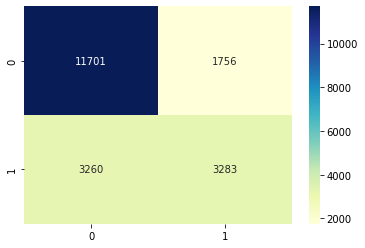

In [ ]:
# xgboost 성능 확인
get_clf_eval(y_valid, y_pred_xgb)


정확도: 0.7460
정밀도: 0.6073
재현율: 0.6330
AUC: 0.7170
F1: 0.6199


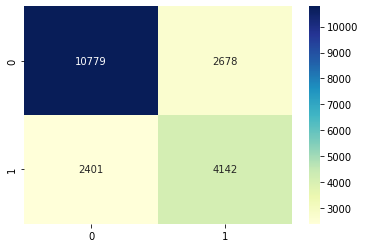

In [ ]:
# threshold 변경 및 성능 확인
# get_clf_eval(y_valid, y_pred_prob[:,1]>0.4)
get_clf_eval(y_valid, xgb_clf.predict_proba(X_valid)[:,1]>0.4)

# Ensemble(Voting)

In [ ]:
rnd_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier()
# rid_clf = RidgeClassifier()
# dtc_clf = DecisionTreeClassifier()
# svm_clf = SVC()
# ada_clf = AdaBoostClassifier()
# gbc_clf = GradientBoostingClassifier()
# bag_clf = BaggingClassifier()
# ext_clf = ExtraTreesClassifier()
# knn_clf = KNeighborsClassifier()
# svc_clf = SVC()

voting_clf = VotingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], voting='soft')


정확도: 0.7459
정밀도: 0.6090
재현율: 0.6237
AUC: 0.7145
F1: 0.6163


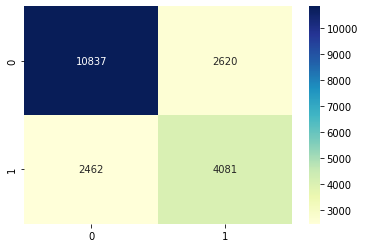

In [ ]:
for clf in (rnd_clf, lgbm_clf, xgb_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred_vote = clf.predict_proba(X_valid)[:,1]>0.4 # threshold 변경

# ensemble(voting) 성능 확인
get_clf_eval(y_valid, y_pred_vote)

# Ensemble(Stacking)


정확도: 0.7519
정밀도: 0.6574
재현율: 0.5045
AUC: 0.6883
F1: 0.5709


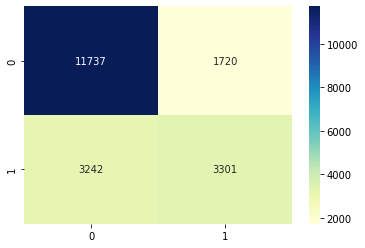

In [ ]:
stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.6886
정밀도: 0.5152
재현율: 0.8175
AUC: 0.7218
F1: 0.6321


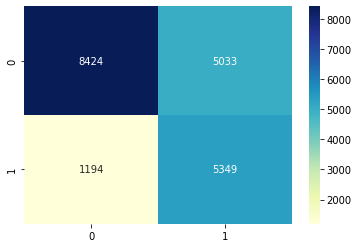

In [ ]:
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.3)


정확도: 0.7325
정밀도: 0.5747
재현율: 0.7011
AUC: 0.7244
F1: 0.6316


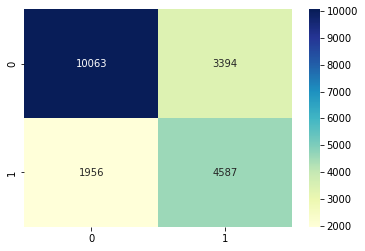

In [ ]:
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.4)


정확도: 0.7151
정밀도: 0.5465
재현율: 0.7591
AUC: 0.7264
F1: 0.6355


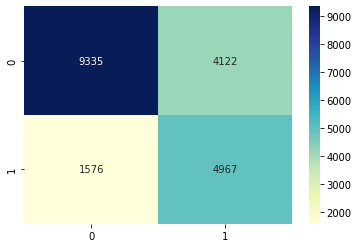

In [ ]:
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.35)

# Submission

In [ ]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# prediction 수행
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.35
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/prediction4.csv', index=False)

In [ ]:
submit.head()

,ID,answer
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
